In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import os, copy
import time

import util_functions as fs
import imp
imp.reload(fs)

%matplotlib inline

In [2]:
#Read music sheets - Binary thresholding and resizing
sheets = fs.get_images('../data/test_sheets', resize_factor=1, threshold=200)

>>> Folder : ../data/test_sheets : 14 files
01 : ../data/test_sheets/Sample01.jpg : (1657, 1177)
02 : ../data/test_sheets/Sample02.jpg : (1353, 1174)
03 : ../data/test_sheets/fire.jpg : (3508, 2479)
04 : ../data/test_sheets/hush.jpg : (1100, 850)
05 : ../data/test_sheets/kookaburra.jpg : (1453, 2453)
06 : ../data/test_sheets/mary.jpg : (1288, 2456)
07 : ../data/test_sheets/p1 (1).jpg : (2339, 1653)
08 : ../data/test_sheets/p1.jpg : (2339, 1653)
09 : ../data/test_sheets/p1.png : (1809, 1280)
10 : ../data/test_sheets/p2 (1).jpg : (2339, 1653)
11 : ../data/test_sheets/p2.jpg : (2339, 1653)
12 : ../data/test_sheets/p2.png : (1809, 1280)
13 : ../data/test_sheets/races.jpg : (1600, 1465)
14 : ../data/test_sheets/teapot.jpg : (1101, 851)
>>> Inverse binary thresholding with threshold value 200


In [3]:
#Pick Sample page
sample_image = sheets[8]

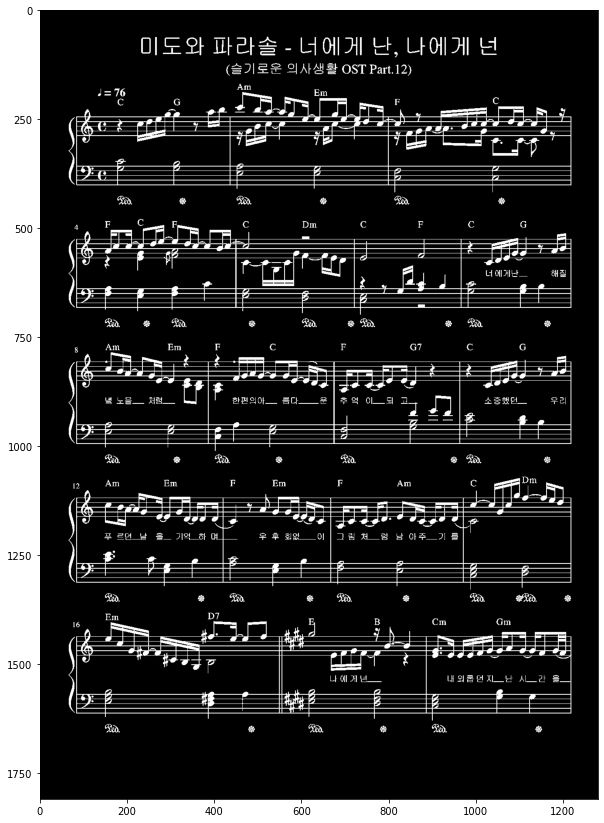

In [4]:
#Show sample
fs.plot_single_image(sample_image, off_axis=False)

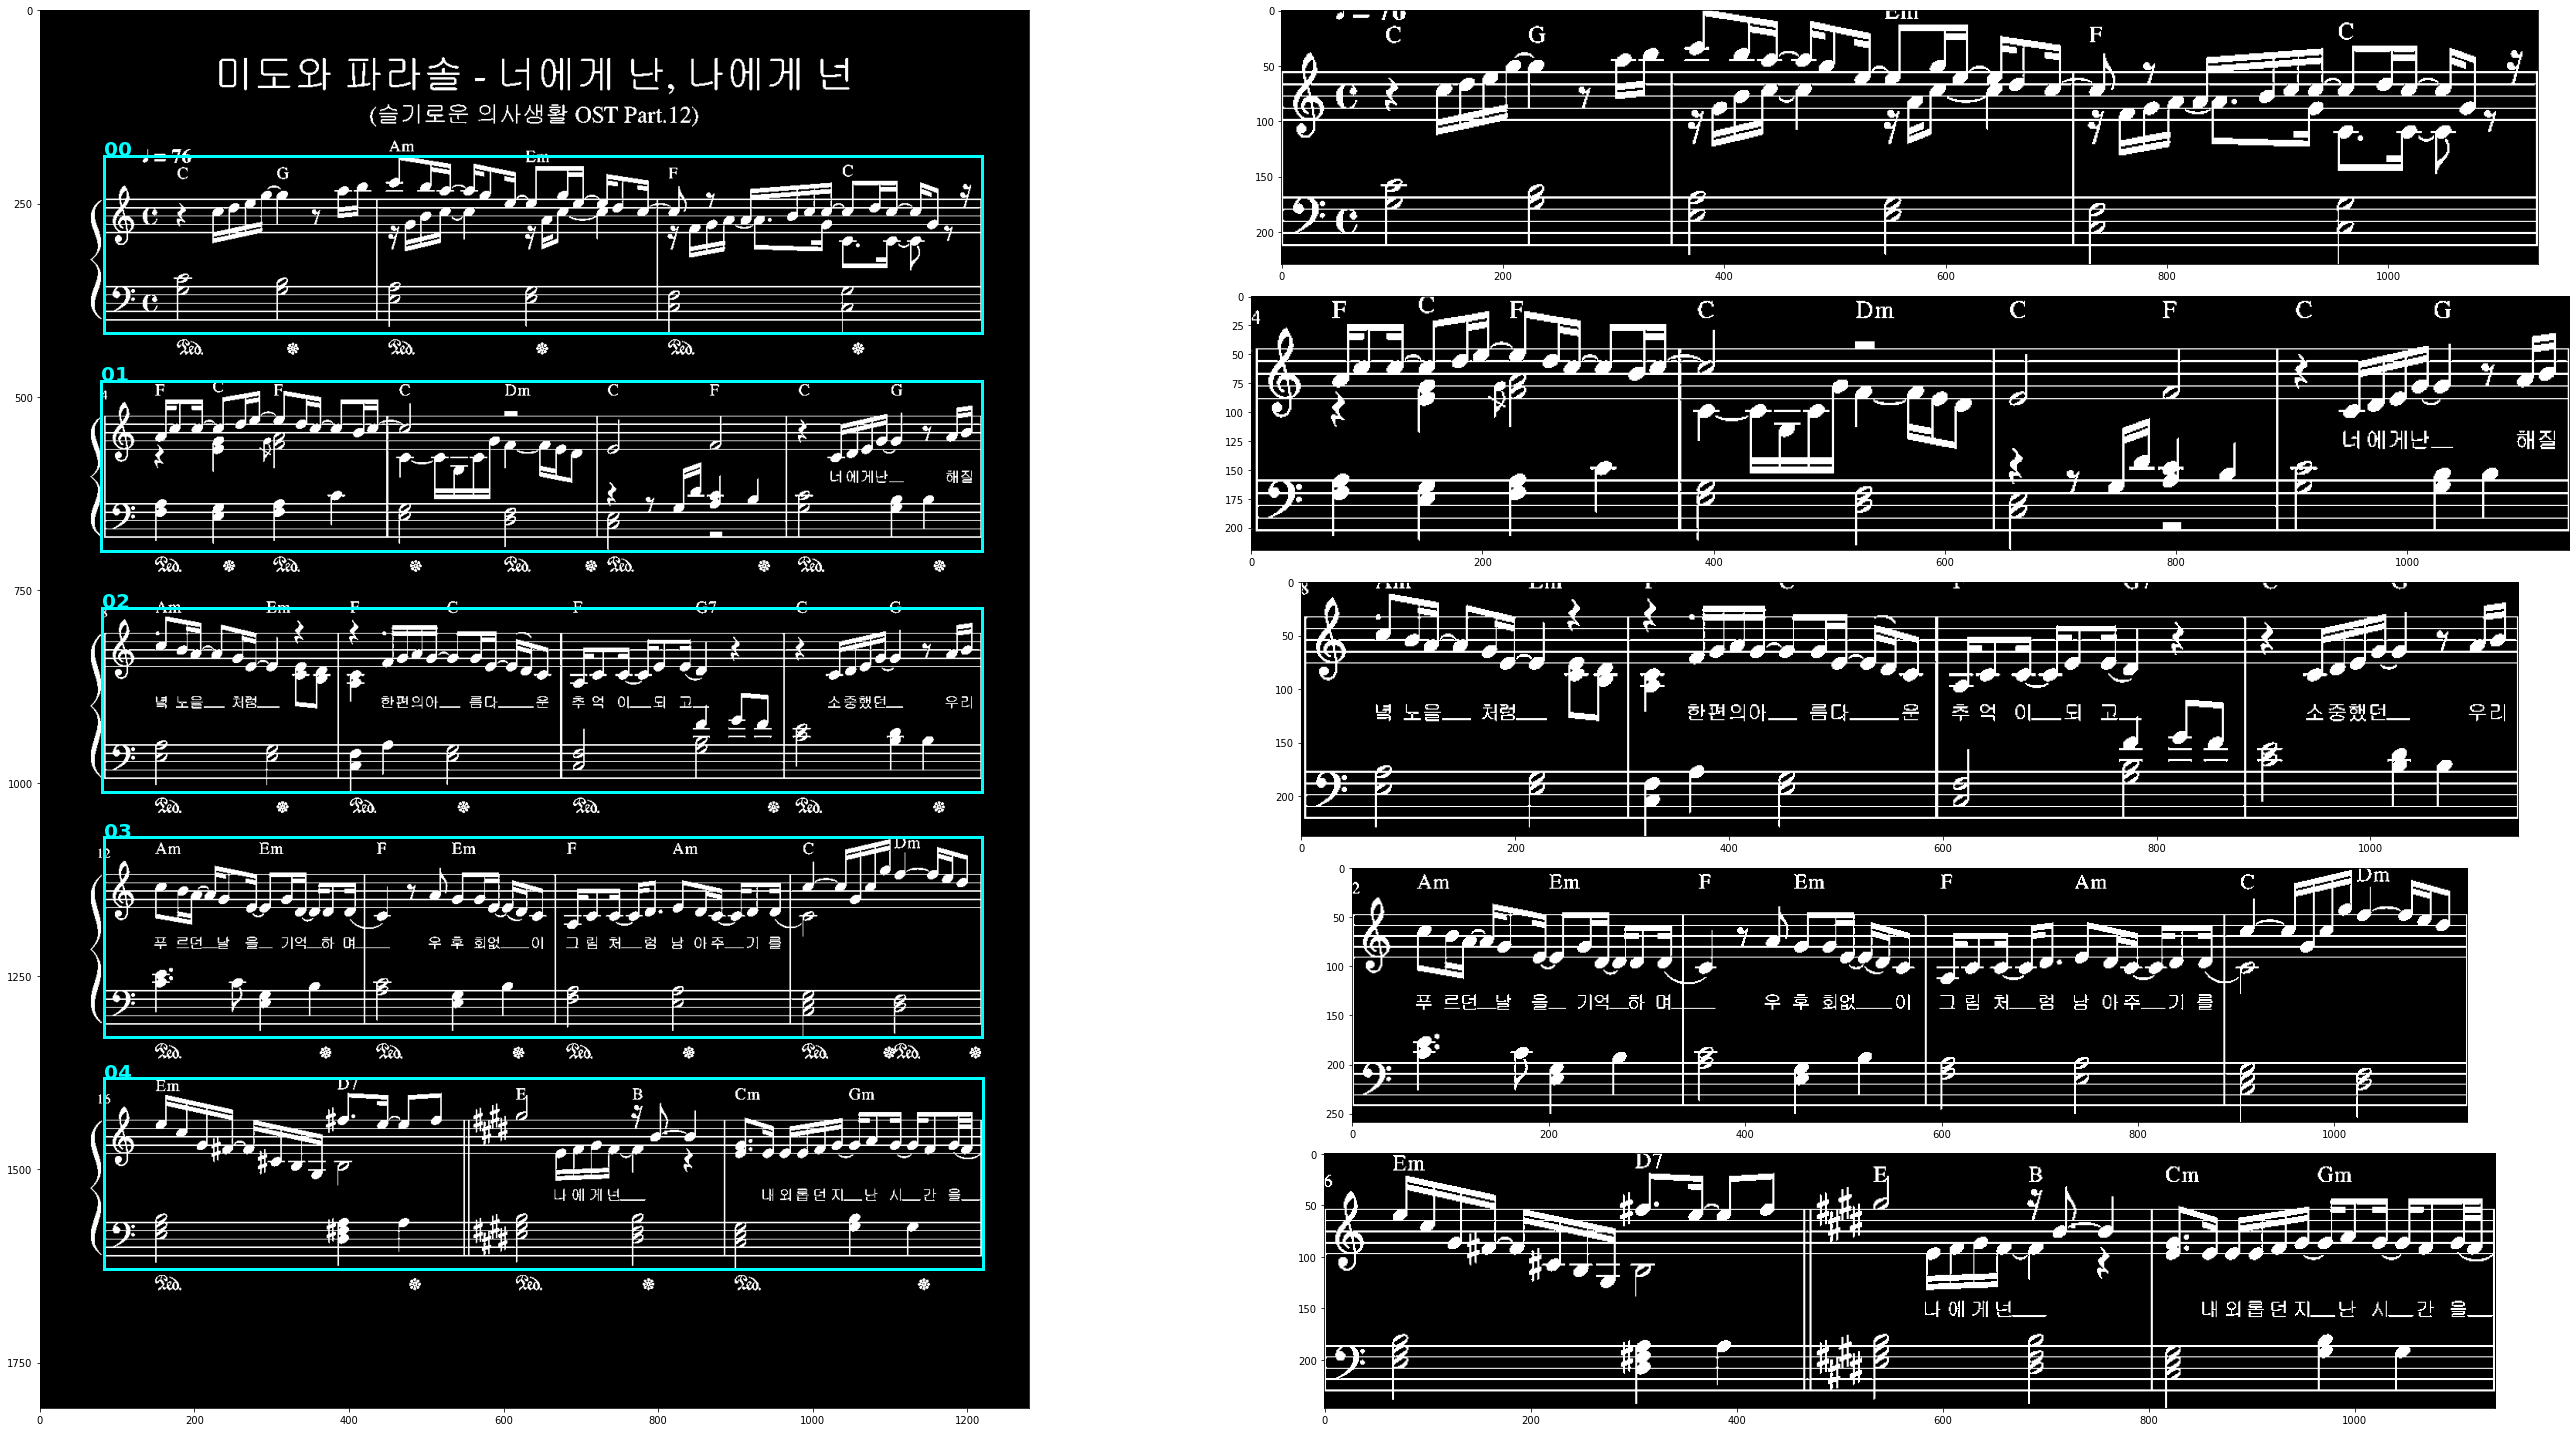

In [5]:
#Extract main components of sheet
main_components, pos, _ = fs.get_main_components(sample_image)
#Rearrange position of main components
main_components, pos = fs.arrange_components_idx(main_components, pos)

#Show show components
fig = plt.figure(figsize=(40,20))
ax = plt.subplot2grid((len(main_components), 2), (0, 0), rowspan=len(main_components))
ax.imshow(sample_image, cmap='gray')

for i, (x, y, w, h, area) in enumerate(pos):  #Highlighting
    ax.add_patch(patches.Rectangle((x, y), w, h, edgecolor='cyan', fill=False, linewidth=3))
    ax.text(x, y, f'{i:02d}', color='cyan', fontsize=20, fontweight='bold')

for i in range(len(main_components)):  #Show only component
    ax = plt.subplot2grid((len(main_components), 2), (i, 1))
    ax.imshow(main_components[i], cmap='gray')

fig.set_tight_layout(True)
plt.show() 

In [6]:
def get_staff_lines(hist_image_col):
    line_pos = hist_image_col.nonzero()[0]
    cur_thickness = 1
    i = 0
    hlines, thicknesses = [], []
    
    while i<len(line_pos):
        if cur_thickness == 1:
            hlines.append(line_pos[i])
            
        if i == int(len(line_pos)-1):
            thicknesses.append(cur_thickness)
        elif line_pos[i]+1 == line_pos[i+1]:
            cur_thickness += 1
        else:
            thicknesses.append(cur_thickness)
            cur_thickness = 1
        i += 1
        
    return hlines, thicknesses

def remove_single_hline(image_, line_from, thickness, b=255, w=0):
    image = image_.copy()
    line_to = line_from+thickness-1
    height, width = image.shape
    
    for col in range(width):
        if image[line_from, col] == b or image[line_to,col] == b:
            if image[line_from-1, col] == w and image[line_to+1, col] == w:
                for i in range(thickness):
                    image[line_from+i, col] = w
        
            elif image[line_from-1, col] == w and image[line_to+1, col] == b:
                if(col>0 and image[line_to+1, col-1] != b) and (col<width-1 and image[line_to+1, col+1] != b):
                    thick = thickness+1
                    if thick<1:
                        thick = 1
                    for i in range(int(thick)):
                        image[line_from+i, col] = w
            
            elif image[line_from-1, col] == b and image[line_to+1, col] == w:
                if (col>0 and image[line_from-1, col-1] != b) and (col<width-1 and image[line_from-1, col+1] != b):
                    thick = thickness+1
                    if thick<1:
                        for i in range(int(thick)):
                            image[line_to-i, col] = w
    
    return image

def remove_hlines(image_, line_idxs, thicknesses, b=255, w=0):
    image = image_.copy()
    for line_from, thickness in zip(line_idxs, thicknesses):
        image = remove_single_hline(image, line_from, thickness, b=b, w=w)
        
    return image

[56, 67, 78, 89, 99, 169, 180, 191, 201, 212] [2, 2, 1, 1, 2, 2, 1, 1, 2, 2]
[46, 56, 67, 78, 89, 159, 170, 181, 192, 202] [1, 2, 2, 1, 1, 2, 2, 1, 1, 2]
[33, 44, 54, 65, 76, 177, 188, 199, 210, 220] [1, 1, 2, 2, 1, 2, 2, 1, 1, 2]
[48, 59, 69, 80, 91, 198, 209, 220, 231, 241] [1, 1, 2, 2, 1, 2, 2, 1, 1, 2]
[54, 65, 75, 86, 97, 186, 197, 208, 218, 229] [1, 1, 2, 2, 1, 2, 1, 1, 2, 2]


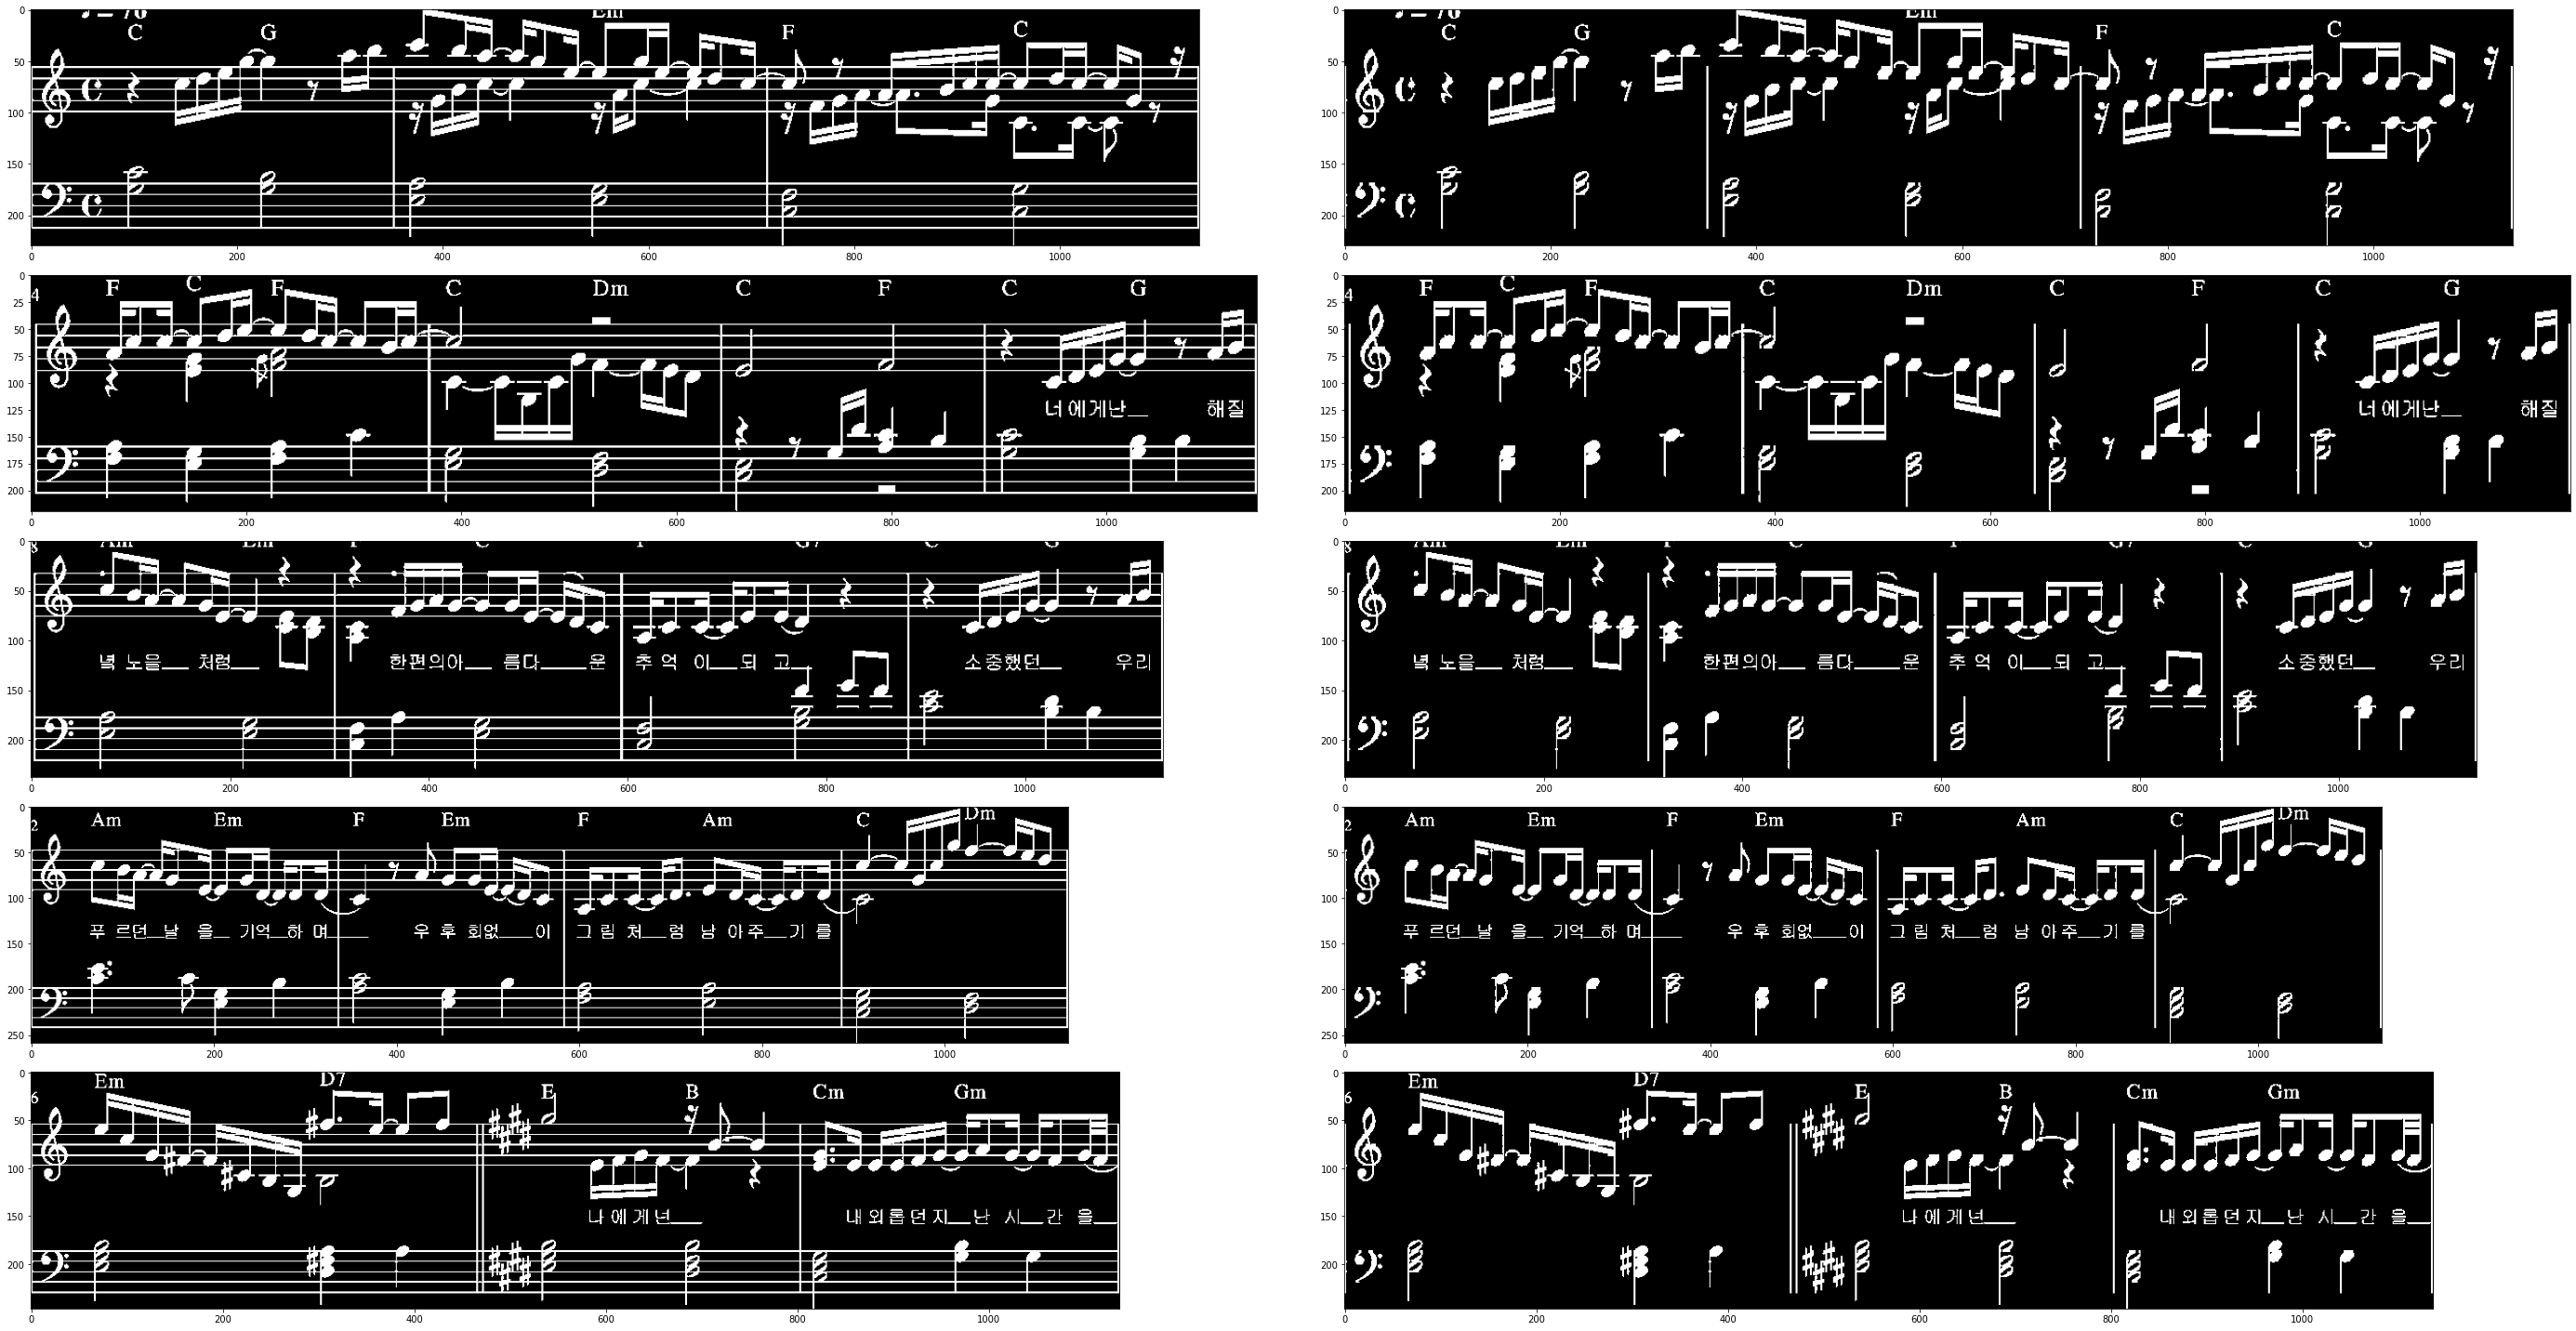

Runtime : 13.69 sec


In [7]:
ts = time.time()
vline_opt = ['red', 'darkorange', 'gold', 'greenyellow', 'aquamarine', 'skyblue']

fig = plt.figure(figsize=(40,20))
for i, component in enumerate(main_components):
    hist_image, hist_data, grid, grid_idx = fs.get_pixel_histogram(component, grid=[0.3, 0.5, 0.6, 0.7, 0.8, 0.9])
    hlines, thicknesses = get_staff_lines(hist_image[:,grid_idx[-2]])
    print(hlines, thicknesses)
    
    ax = plt.subplot2grid((len(main_components), 2), (i, 0))
    ax.imshow(main_components[i], cmap='gray')
    ax.set_anchor('W')
    
    ax = plt.subplot2grid((len(main_components), 2), (i, 1))

    image2 = remove_hlines(main_components[i], hlines, thicknesses)
    ax.imshow(image2, cmap='gray')
    ax.set_anchor('W')
    
    main_components[i] = image2
    
fig.set_tight_layout(True)
plt.show() 

tf = time.time()
print(f'Runtime : {tf-ts:.2f} sec')

In [8]:
def extract_symbols(image):
    img_height, img_width = image.shape
    """
    blurred = cv2.GaussianBlur(in_img, (3, 3), 0)
    thresh = cv2.threshold(blurred, 160, 255, cv2.THRESH_BINARY_INV)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilate = cv2.dilate(thresh, kernel, iterations=1)
    """
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2 ,2))
    image = cv2.erode(image, kernel, iterations=1)

    image = cv2.dilate(image, kernel, iterations=1)
    
    
        # Find contours in the image
    cnts, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    print(type(cnts), len(cnts))
    
    threshold_min_area = 0
    threshold_max_area = img_height*img_width

    symbols = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        if area > threshold_min_area and area < threshold_max_area:
            symbols.append([x, y, x+w, y+h])
        #else:
        #    print(f'Passed : {x, y, w, h}')

    return symbols, image, cnts

In [9]:
#Method1 - github : OMR project "Orchestra"

ts = time.time()

fig = plt.figure(figsize=(40,20))
for i, component in enumerate(main_components[:1]):
    
    print(symbol_infos)
    
    ax = plt.subplot2grid((len(main_components), 2), (i, 0))
    ax.imshow(main_components[i], cmap='gray')
    
    for x, y, w, h in symbol_infos:
        ax.add_patch(patches.Rectangle((x, y), w, h, edgecolor='gold', fill=False, linewidth=1))
    
    ax.set_anchor('W')
    
    symbol_infos, dilated_image, cnts = extract_symbols(component)
    
    ax = plt.subplot2grid((len(main_components), 2), (i, 1))

    
    ax.imshow(dilated_image, cmap='gray')

    ax.set_anchor('W')
    
    
fig.set_tight_layout(True)
plt.show() 

tf = time.time()
print(f'Runtime : {tf-ts:.2f} sec')

NameError: name 'symbol_infos' is not defined

<Figure size 2880x1440 with 0 Axes>